In [8]:
import h5py
import numpy as np
from pathlib import Path

In [9]:
# Path to the HDF5 file
h5_file_path = Path('/media/nvidia/T7/Demo/demo_0.h5')
print(f"File path: {h5_file_path}")
print(f"File exists: {h5_file_path.exists()}")

File path: /media/nvidia/T7/Demo/demo_0.h5
File exists: True


In [10]:
def print_structure(name, obj, indent=0):
    """Recursively print the structure of HDF5 file"""
    spacing = "  " * indent
    
    if isinstance(obj, h5py.Group):
        print(f"{spacing}📁 Group: {name}")
        print(f"{spacing}   Attributes: {dict(obj.attrs)}")
    elif isinstance(obj, h5py.Dataset):
        print(f"{spacing}📄 Dataset: {name}")
        print(f"{spacing}   Shape: {obj.shape}")
        print(f"{spacing}   Dtype: {obj.dtype}")
        print(f"{spacing}   Size: {obj.size}")
        print(f"{spacing}   Attributes: {dict(obj.attrs)}")
        
def visualize_h5_structure(file_path):
    """Visualize the complete structure of an HDF5 file"""
    with h5py.File(file_path, 'r') as f:
        print("="*70)
        print(f"HDF5 File Structure: {file_path.name}")
        print("="*70)
        print(f"\nRoot attributes: {dict(f.attrs)}\n")
        
        # Use visititems to traverse all objects
        f.visititems(print_structure)
        
        print("\n" + "="*70)
        print("Summary:")
        print("="*70)
        
        # Count groups and datasets
        groups = []
        datasets = []
        
        def collect_items(name, obj):
            if isinstance(obj, h5py.Group):
                groups.append(name)
            elif isinstance(obj, h5py.Dataset):
                datasets.append(name)
        
        f.visititems(collect_items)
        
        print(f"Total Groups: {len(groups)}")
        print(f"Total Datasets: {len(datasets)}")
        
        return groups, datasets

In [11]:
# Visualize the HDF5 file structure
groups, datasets = visualize_h5_structure(h5_file_path)

HDF5 File Structure: demo_0.h5

Root attributes: {}

📁 Group: head_depth
   Attributes: {}
📁 Group: head_rgb
   Attributes: {}
📁 Group: pointclouds
   Attributes: {}
📁 Group: right_depth
   Attributes: {}
📁 Group: right_rgb
   Attributes: {}
📁 Group: samples
   Attributes: {}

Summary:
Total Groups: 6
Total Datasets: 0


In [12]:
# Detailed inspection of specific datasets
with h5py.File(h5_file_path, 'r') as f:
    print("\n" + "="*70)
    print("Detailed Dataset Information:")
    print("="*70)
    
    for dataset_name in datasets:
        dataset = f[dataset_name]
        print(f"\n📊 Dataset: {dataset_name}")
        print(f"   Shape: {dataset.shape}")
        print(f"   Dtype: {dataset.dtype}")
        
        # Skip variable-length datasets (like pointcloud data)
        if dataset.dtype == 'object':
            print(f"   Type: Variable-length dataset")
            if dataset.size > 0:
                first_elem = dataset[0]
                print(f"   First element length: {len(first_elem) if hasattr(first_elem, '__len__') else 'scalar'}")
                if hasattr(first_elem, '__len__') and len(first_elem) > 0:
                    print(f"   First element sample: {first_elem[:min(10, len(first_elem))]}...")
        else:
            # Regular datasets
            try:
                print(f"   Min/Max: {np.min(dataset[:])} / {np.max(dataset[:])}")
            except:
                print(f"   Min/Max: Unable to compute")
            
            # Show first few values if dataset is not too large
            if dataset.size <= 100:
                print(f"   Values preview:\n{dataset[:]}")
            else:
                print(f"   First 5 values: {dataset[:5]}")
                print(f"   Last 5 values: {dataset[-5:]}")


Detailed Dataset Information:


In [13]:
# Create a tree visualization
def create_tree_visualization(file_path):
    """Create a tree-like visualization of the HDF5 structure"""
    
    def tree_structure(name, obj, prefix="", is_last=True):
        """Recursively create tree structure"""
        connector = "└── " if is_last else "├── "
        
        if isinstance(obj, h5py.Group):
            print(f"{prefix}{connector}📁 {name.split('/')[-1] if '/' in name else name}")
        elif isinstance(obj, h5py.Dataset):
            shape_str = f"{obj.shape}" if len(obj.shape) > 0 else "scalar"
            print(f"{prefix}{connector}📄 {name.split('/')[-1] if '/' in name else name} {shape_str} [{obj.dtype}]")
    
    with h5py.File(file_path, 'r') as f:
        print("\n" + "="*70)
        print("Tree Structure Visualization:")
        print("="*70)
        print(f"\n📦 {file_path.name}")
        
        items = list(f.items())
        for i, (name, obj) in enumerate(items):
            is_last = (i == len(items) - 1)
            tree_structure(name, obj, "", is_last)
            
            # If it's a group, show its children
            if isinstance(obj, h5py.Group):
                sub_items = list(obj.items())
                for j, (sub_name, sub_obj) in enumerate(sub_items):
                    sub_is_last = (j == len(sub_items) - 1)
                    sub_prefix = "    " if is_last else "│   "
                    tree_structure(sub_name, sub_obj, sub_prefix, sub_is_last)

create_tree_visualization(h5_file_path)


Tree Structure Visualization:

📦 demo_0.h5
├── 📁 head_depth
├── 📁 head_rgb
├── 📁 pointclouds
├── 📁 right_depth
├── 📁 right_rgb
└── 📁 samples


## Analyze Robot Target Data

Compare actual robot positions with target joint angles computed from IK

In [14]:
# Load and compare robot position vs target joints
with h5py.File(h5_file_path, 'r') as f:
    if 'samples' in f and len(f['samples'].keys()) > 0:
        print("="*70)
        print("Robot Joint Data Analysis")
        print("="*70)
        
        if 'robot_position' in f['samples']:
            robot_pos = f['samples/robot_position'][:]
            print(f"\n✅ Robot Position (Current): {robot_pos.shape}")
            print(f"   First sample: {robot_pos[0] if len(robot_pos) > 0 else 'No data'}")
        
        if 'robot_target_cartesian' in f['samples']:
            target_cart = f['samples/robot_target_cartesian'][:]
            print(f"\n✅ Robot Target (Cartesian): {target_cart.shape}")
            print(f"   Format: [right_xyz(3), left_xyz(3), torso_xyz(3)]")
            print(f"   First sample: {target_cart[0] if len(target_cart) > 0 else 'No data'}")
            for i in range(len(target_cart)):
                print(f"   Sample {i}: {target_cart[i]}")  
        
        if 'robot_target_joints' in f['samples']:
            target_joints = f['samples/robot_target_joints'][:]
            print(f"\n✅ Robot Target (Joint Angles): {target_joints.shape}")
            print(f"   First sample: {target_joints[0] if len(target_joints) > 0 else 'No data'}")
            for i in range(len(target_joints)):
                print(f"   Sample {i}: {target_joints[i]}")
            
            # Check if IK succeeded (not all NaN)
            if len(target_joints) > 0:
                valid_samples = ~np.isnan(target_joints).all(axis=1)
                print(f"   Valid IK solutions: {valid_samples.sum()} / {len(target_joints)}")
                
                if valid_samples.sum() > 0 and 'robot_position' in f['samples']:
                    # Compute difference between target and actual
                    diff = target_joints[valid_samples] - robot_pos[valid_samples]
                    print(f"\n📊 Joint Angle Errors (target - actual):")
                    print(f"   Mean error: {np.rad2deg(np.nanmean(np.abs(diff), axis=0))} degrees")
                    print(f"   Max error:  {np.rad2deg(np.nanmax(np.abs(diff), axis=0))} degrees")
    else:
        print("No sample data found in the file.")

No sample data found in the file.


In [15]:
# Visualize joint trajectories
import matplotlib.pyplot as plt

with h5py.File(h5_file_path, 'r') as f:
    if 'samples' in f and 'robot_position' in f['samples'] and 'robot_target_joints' in f['samples']:
        robot_pos = f['samples/robot_position'][:]
        target_joints = f['samples/robot_target_joints'][:]
        time = f['samples/time'][:]
        
        if len(robot_pos) > 0:
            # Plot first 6 joints (torso)
            fig, axes = plt.subplots(3, 2, figsize=(12, 10))
            fig.suptitle('Robot Joint Trajectories: Actual vs Target (First 6 Joints - Torso)', fontsize=14)
            
            for i in range(min(6, robot_pos.shape[1])):
                ax = axes[i // 2, i % 2]
                ax.plot(time, np.rad2deg(robot_pos[:, i]), label='Actual', linewidth=2)
                ax.plot(time, np.rad2deg(target_joints[:, i]), label='Target (IK)', linestyle='--', alpha=0.7)
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Angle (degrees)')
                ax.set_title(f'Joint {i+1}')
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"✅ Plotted {min(6, robot_pos.shape[1])} joint trajectories")
        else:
            print("No data to plot")
    else:
        print("Required datasets not found in file")

Required datasets not found in file


## Visualize Depth Images

Display RGB and Depth images side by side

✅ RGB Images: (8, 480, 640, 3)
   Frame count: 8
   Time range: 920569336.00s to 174872559.00s

✅ Depth Images: (8, 480, 848)
   Frame count: 8
   Time range: 953907715.00s to 208210938.00s
   Depth range: 0 to 8048 mm


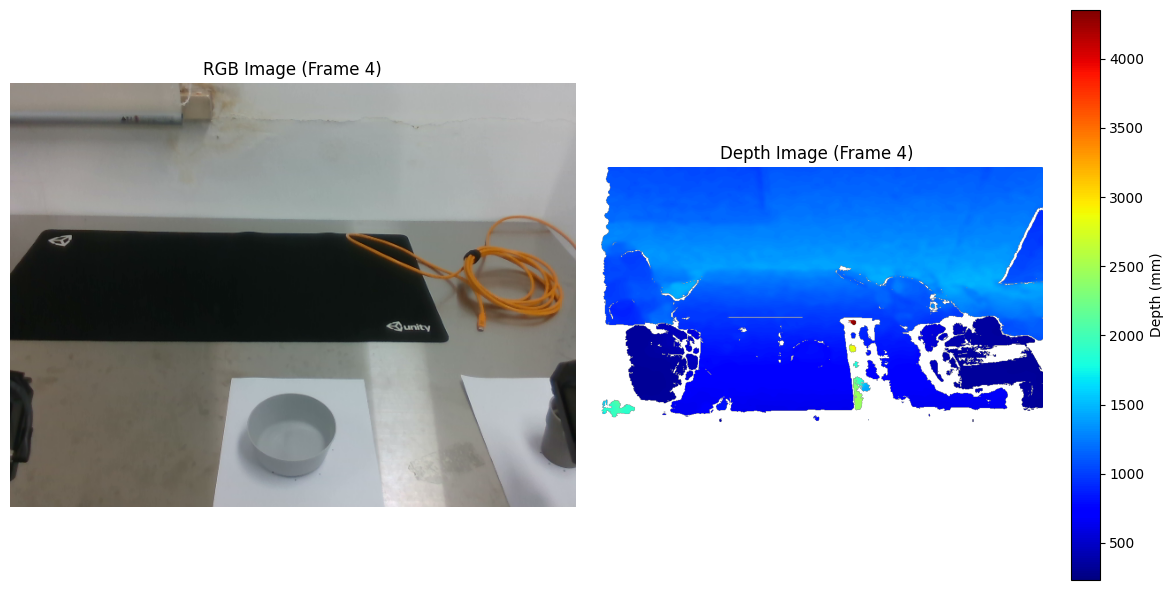

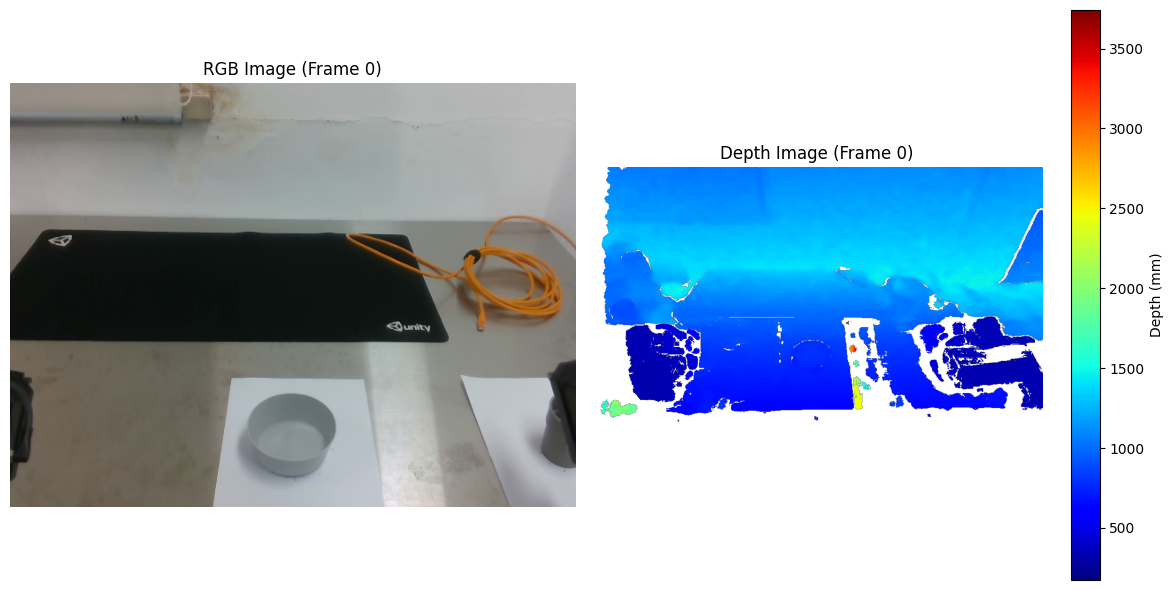

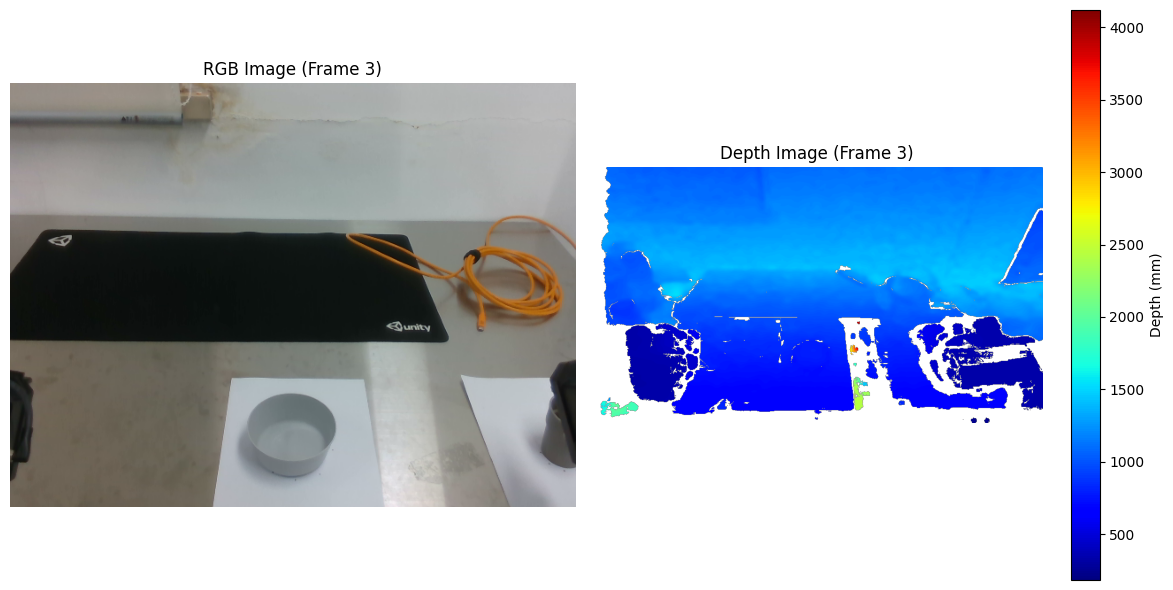

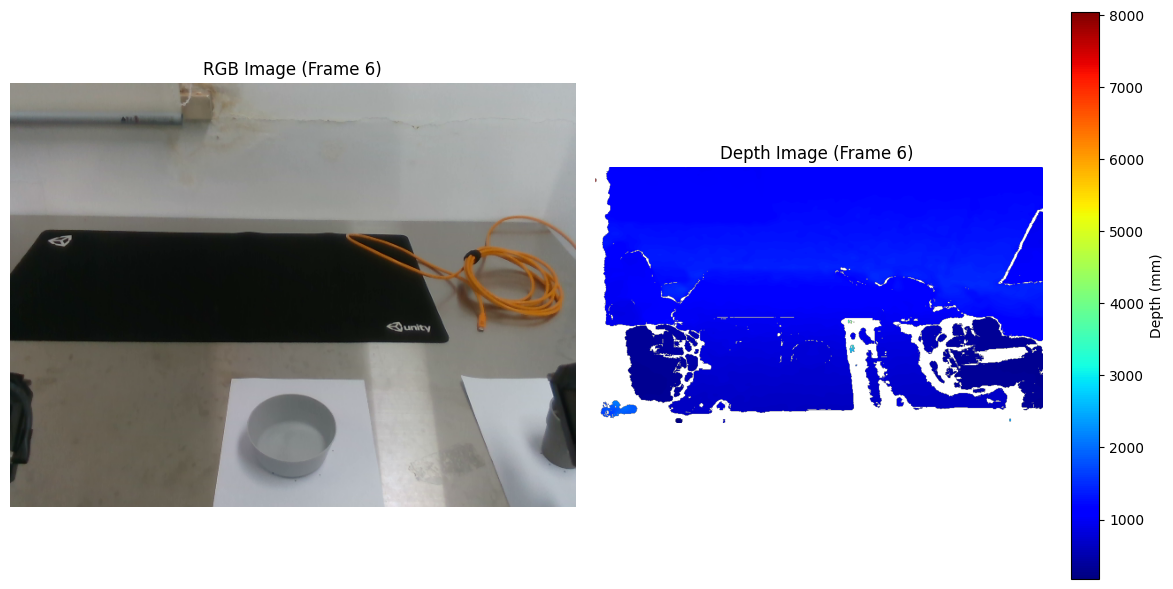


No images to display


In [ ]:
# Display RGB and Depth images
h5_file_path = Path('/media/nvidia/T7/Demo/demo_2.h5')
with h5py.File(h5_file_path, 'r') as f:
    if 'head_rgb' in f and 'image' in f['head_rgb']:
        rgb_images = f['head_rgb/image'][:]
        rgb_times = f['head_rgb/time'][:]
        print(f"✅ RGB Images: {rgb_images.shape}")
        print(f"   Frame count: {len(rgb_images)}")
        print(f"   Time range: {rgb_times[0]:.2f}s to {rgb_times[-1]:.2f}s" if len(rgb_times) > 0 else "   No timestamps")
    else:
        rgb_images = None
        print("❌ No RGB images found")
    
    if 'head_depth' in f and 'image' in f['head_depth']:
        depth_images = f['head_depth/image'][:]
            
        depth_times = f['head_depth/time'][:]
        print(f"\n✅ Depth Images: {depth_images.shape}")
        print(f"   Frame count: {len(depth_images)}")
        print(f"   Time range: {depth_times[0]:.2f}s to {depth_times[-1]:.2f}s" if len(depth_times) > 0 else "   No timestamps")
        print(f"   Depth range: {depth_images.min()} to {depth_images.max()} mm")
    else:
        depth_images = None
        print("\n❌ No depth images found")
    
    # Display a sample frame
    if rgb_images is not None and len(rgb_images) > 0:
        sample_idx = len(rgb_images) // 2  # middle frame
        
        fig, axes = plt.subplots(1, 2 if depth_images is not None else 1, figsize=(12, 6))
        
        if depth_images is not None:
            # RGB
            axes[0].imshow(rgb_images[sample_idx])
            axes[0].set_title(f'RGB Image (Frame {sample_idx})')
            axes[0].axis('off')
            
            # Depth (colorized)
            depth_colorized = depth_images[sample_idx].astype(float)
            # Normalize for visualization
            depth_colorized[depth_colorized == 0] = np.nan  # Remove zeros
            im = axes[1].imshow(depth_colorized, cmap='jet')
            axes[1].set_title(f'Depth Image (Frame {sample_idx})')
            axes[1].axis('off')
            plt.colorbar(im, ax=axes[1], label='Depth (mm)')
        else:
            axes.imshow(rgb_images[sample_idx])
            axes.set_title(f'RGB Image (Frame {sample_idx})')
            axes.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo images to display")
    
    # Display all frame
    if rgb_images is not None and len(rgb_images) > 0:
        for sample_idx in range(0, len(rgb_images),3):
            fig, axes = plt.subplots(1, 2 if depth_images is not None else 1, figsize=(12, 6))
            
            if depth_images is not None:
                # RGB
                axes[0].imshow(rgb_images[sample_idx])
                axes[0].set_title(f'RGB Image (Frame {sample_idx})')
                axes[0].axis('off')
                
                # Depth (colorized)
                depth_colorized = depth_images[sample_idx].astype(float)
                # Normalize for visualization
                depth_colorized[depth_colorized == 0] = np.nan  # Remove zeros
                im = axes[1].imshow(depth_colorized, cmap='jet')
                axes[1].set_title(f'Depth Image (Frame {sample_idx})')
                axes[1].axis('off')
                plt.colorbar(im, ax=axes[1], label='Depth (mm)')
            else:
                axes.imshow(rgb_images[sample_idx])
                axes.set_title(f'RGB Image (Frame {sample_idx})')
                axes.axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo images to display")
    

## [Legacy] Manual RGB-D to PCD Conversion

⚠️ **This section is for OLD H5 files without embedded PCD data.**

**New files (created after PCD support):**
- Point clouds are automatically generated during data collection
- Stored in the `pointclouds` group inside the H5 file
- No manual conversion needed!

**Use this section only if:**
- Your H5 file was created before PCD support was added
- The `pointclouds` group is missing in your H5 file

## Point Cloud Data Analysis

Point clouds are automatically generated during data collection and stored in the `pointclouds` group.

**What's stored:**
- `pointclouds/time`: Timestamps for each frame
- `pointclouds/points`: 3D coordinates (X, Y, Z) in meters
- `pointclouds/colors`: RGB color values (0-255)

**Data format:**
- Variable-length arrays (each frame can have different number of points)
- Compressed with gzip for efficient storage
- Synchronized with RGB-D images

In [10]:
# Read point cloud data from HDF5
with h5py.File(h5_file_path, 'r') as f:
    if 'pointclouds' in f:
        pcd_grp = f['pointclouds']
        if 'points' in pcd_grp and 'colors' in pcd_grp:
            pcd_times = pcd_grp['time'][:]
            pcd_points = pcd_grp['points']
            pcd_colors = pcd_grp['colors']
            
            print(f"✅ Point Cloud Data found in H5 file")
            print(f"   Number of point clouds: {len(pcd_times)}")
            if len(pcd_times) > 0:
                print(f"   Time range: {pcd_times[0]:.2f}s to {pcd_times[-1]:.2f}s")
            
            # Check first point cloud
            if len(pcd_points) > 0:
                first_points = np.array(pcd_points[0]).reshape(-1, 3)
                first_colors = np.array(pcd_colors[0]).reshape(-1, 3)
                print(f"\n   First point cloud:")
                print(f"     Points: {len(first_points):,}")
                print(f"     Point shape: {first_points.shape}")
                print(f"     Color shape: {first_colors.shape}")
                print(f"     X range: [{first_points[:, 0].min():.3f}, {first_points[:, 0].max():.3f}] m")
                print(f"     Y range: [{first_points[:, 1].min():.3f}, {first_points[:, 1].max():.3f}] m")
                print(f"     Z range: [{first_points[:, 2].min():.3f}, {first_points[:, 2].max():.3f}] m")
                
                # Storage info
                total_points = sum(len(np.array(pcd_points[i])) // 3 for i in range(len(pcd_points)))
                print(f"\n   Storage statistics:")
                print(f"     Total frames: {len(pcd_points)}")
                print(f"     Total points: {total_points:,}")
                print(f"     Avg points/frame: {total_points // len(pcd_points):,}")
        else:
            print("❌ Point cloud datasets not found in pointclouds group")
    else:
        print("❌ No pointclouds group found in H5 file")
        print("   This file may have been created before PCD support was added")
        print("   Point clouds are now automatically generated during data collection")

✅ Point Cloud Data found in H5 file
   Number of point clouds: 145
   Time range: 901989502.00s to 977753418.00s

   First point cloud:
     Points: 301,892
     Point shape: (301892, 3)
     Color shape: (301892, 3)
     X range: [-0.707, 0.516] m
     Y range: [-0.439, 0.647] m
     Z range: [0.209, 1.950] m



   Storage statistics:
     Total frames: 145
     Total points: 44,270,603
     Avg points/frame: 305,314


### Point Cloud Statistics and Quality

Analyze point cloud quality and characteristics

Point Cloud Quality Analysis

📊 Overall Statistics:
   Total frames: 145
   Total duration: 75763916.00s
   Average frame rate: 0.0 Hz

📈 Point Count Statistics:
   Mean: 305,315 points/frame
   Std:  2,830 points/frame
   Min:  298,196 points/frame
   Max:  311,733 points/frame

📏 Spatial Statistics:
   Avg depth range: 1.749 ± 0.152 m
   Avg spatial extent: 2.381 ± 0.193 m


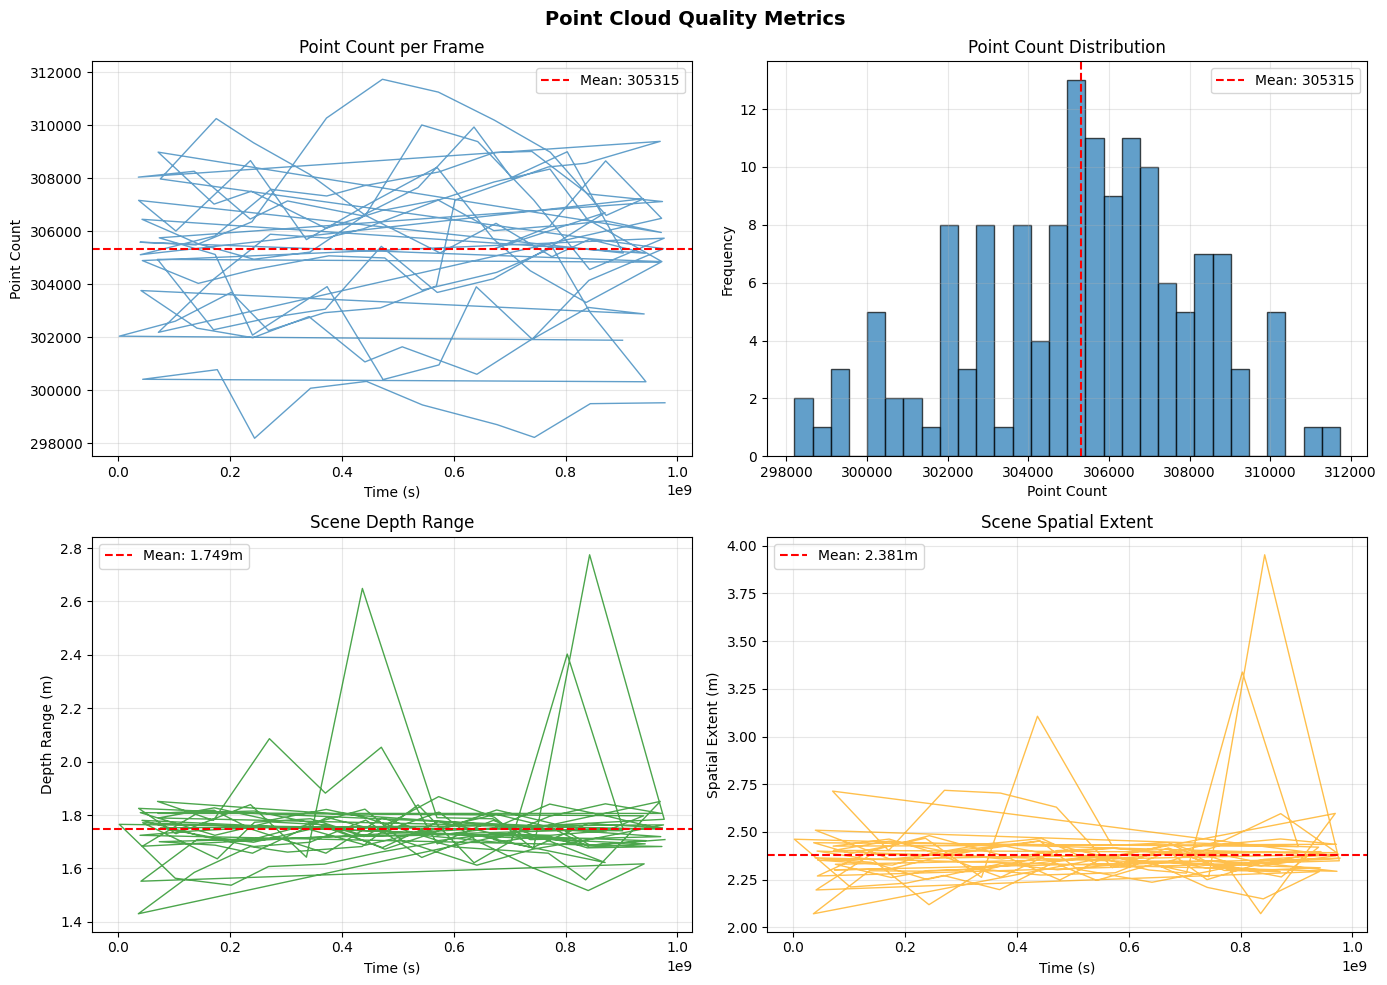


✅ Analysis complete!


: 

In [ ]:
# Analyze point cloud quality and statistics
import matplotlib.pyplot as plt

with h5py.File(h5_file_path, 'r') as f:
    if 'pointclouds' in f and 'points' in f['pointclouds']:
        pcd_points = f['pointclouds/points']
        pcd_times = f['pointclouds/time'][:]
        
        print("="*70)
        print("Point Cloud Quality Analysis")
        print("="*70)
        
        # Collect statistics
        point_counts = []
        depth_ranges = []
        spatial_extents = []
        
        for i in range(len(pcd_points)):
            points = np.array(pcd_points[i]).reshape(-1, 3)
            point_counts.append(len(points))
            
            if len(points) > 0:
                depth_ranges.append(points[:, 2].max() - points[:, 2].min())
                extent = np.sqrt(np.sum((points.max(axis=0) - points.min(axis=0))**2))
                spatial_extents.append(extent)
        
        point_counts = np.array(point_counts)
        depth_ranges = np.array(depth_ranges)
        spatial_extents = np.array(spatial_extents)
        
        print(f"\n📊 Overall Statistics:")
        print(f"   Total frames: {len(pcd_points)}")
        print(f"   Total duration: {pcd_times[-1] - pcd_times[0]:.2f}s")
        print(f"   Average frame rate: {len(pcd_points) / (pcd_times[-1] - pcd_times[0]):.1f} Hz")
        
        print(f"\n📈 Point Count Statistics:")
        print(f"   Mean: {point_counts.mean():,.0f} points/frame")
        print(f"   Std:  {point_counts.std():,.0f} points/frame")
        print(f"   Min:  {point_counts.min():,} points/frame")
        print(f"   Max:  {point_counts.max():,} points/frame")
        
        print(f"\n📏 Spatial Statistics:")
        print(f"   Avg depth range: {depth_ranges.mean():.3f} ± {depth_ranges.std():.3f} m")
        print(f"   Avg spatial extent: {spatial_extents.mean():.3f} ± {spatial_extents.std():.3f} m")
        
        # Plot statistics
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Point Cloud Quality Metrics', fontsize=14, fontweight='bold')
        
        # Point count over time
        ax = axes[0, 0]
        ax.plot(pcd_times, point_counts, linewidth=1, alpha=0.7)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Point Count')
        ax.set_title('Point Count per Frame')
        ax.grid(True, alpha=0.3)
        ax.axhline(point_counts.mean(), color='r', linestyle='--', label=f'Mean: {point_counts.mean():.0f}')
        ax.legend()
        
        # Point count histogram
        ax = axes[0, 1]
        ax.hist(point_counts, bins=30, alpha=0.7, edgecolor='black')
        ax.set_xlabel('Point Count')
        ax.set_ylabel('Frequency')
        ax.set_title('Point Count Distribution')
        ax.axvline(point_counts.mean(), color='r', linestyle='--', label=f'Mean: {point_counts.mean():.0f}')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Depth range over time
        ax = axes[1, 0]
        ax.plot(pcd_times, depth_ranges, linewidth=1, alpha=0.7, color='green')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Depth Range (m)')
        ax.set_title('Scene Depth Range')
        ax.grid(True, alpha=0.3)
        ax.axhline(depth_ranges.mean(), color='r', linestyle='--', label=f'Mean: {depth_ranges.mean():.3f}m')
        ax.legend()
        
        # Spatial extent
        ax = axes[1, 1]
        ax.plot(pcd_times, spatial_extents, linewidth=1, alpha=0.7, color='orange')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Spatial Extent (m)')
        ax.set_title('Scene Spatial Extent')
        ax.grid(True, alpha=0.3)
        ax.axhline(spatial_extents.mean(), color='r', linestyle='--', label=f'Mean: {spatial_extents.mean():.3f}m')
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        print("\n✅ Analysis complete!")
    else:
        print("❌ No pointclouds data found in H5 file")

### Visualize Point Cloud from H5 (requires Open3D)

Load and visualize point cloud directly from HDF5 file

In [ ]:
# 현재 오류 발생하므로 이건 실행 X
# Visualize point cloud from H5 file using Open3D
try:
    import open3d as o3d
    import gc  # Garbage collector for memory management
    
    with h5py.File(h5_file_path, 'r') as f:
        if 'pointclouds' in f and 'points' in f['pointclouds']:
            pcd_points = f['pointclouds/points']
            pcd_colors = f['pointclouds/colors']
            pcd_times = f['pointclouds/time'][:]
            
            if len(pcd_points) > 0:
                # Filter frames to only use 1 second of data (max 10 frames)
                start_time = pcd_times[0]
                end_time = start_time + 1.0  # 1 second window
                
                # Find indices within 1 second
                time_mask = (pcd_times >= start_time) & (pcd_times <= end_time)
                print(time_mask)
                valid_indices = np.where(time_mask)[0]
                print("valid_indices:",valid_indices)
                print("len indices: ",len(valid_indices))


                # Limit to maximum 10 frames
                if len(valid_indices) > 10:
                    # Evenly sample 10 frames from the 1-second window
                    step = max(1, len(valid_indices) // 10)
                    valid_indices = valid_indices[::step][:10]

                
                print(f"Using {len(valid_indices)} frames from first 1 second of data")
                print(f"Time range: {pcd_times[valid_indices[0]]:.2f}s to {pcd_times[valid_indices[-1]]:.2f}s")

                # Load only the middle frame (don't load all frames into memory)
                idx = valid_indices[len(valid_indices) // 2]

                # Load single frame data
                points_raw = pcd_points[idx]
                colors_raw = pcd_colors[idx]

                # Convert to numpy arrays
                points = np.array(points_raw, dtype=np.float64).reshape(-1, 3)
                colors = np.array(colors_raw, dtype=np.uint8).reshape(-1, 3)

                # Free memory
                del points_raw, colors_raw
                gc.collect()

                print(f"\nLoading point cloud frame {idx} (frame {np.where(valid_indices == idx)[0][0] + 1}/{len(valid_indices)} of selected)")
                print(f"Timestamp: {pcd_times[idx]:.2f}s")
                print(f"Points: {len(points):,}")

                if len(points) > 0:
                    z_range = points[:, 2].max() - points[:, 2].min()
                    if z_range > 0:
                        print(f"Point density: {len(points) / z_range:.0f} points/meter")
                    else:
                        print(f"Point density: N/A (z_range = 0)")

                # Create Open3D point cloud
                pcd = o3d.geometry.PointCloud()
                pcd.points = o3d.utility.Vector3dVector(points)
                pcd.colors = o3d.utility.Vector3dVector(colors.astype(np.float32) / 255.0)

                # Estimate normals only if point cloud is not too large
                if len(points) < 100000:
                    try:
                        pcd.estimate_normals(
                            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30)
                        )
                    except Exception as e:
                        print(f"Warning: Could not estimate normals: {e}")
                
                print("\n💡 Visualization controls:")
                print("   - Mouse left: Rotate")
                print("   - Mouse right: Pan")
                print("   - Mouse wheel: Zoom")
                print("   - Press 'H' for help")
                
                # Visualize
                o3d.visualization.draw_geometries(
                    [pcd],
                    window_name=f"Point Cloud from H5 (Frame {idx}, Time: {pcd_times[idx]:.2f}s)",
                    width=1024,
                    height=768,
                    left=50,
                    top=50,
                    point_show_normal=False
                )
                
                # Clean up
                del pcd, points, colors
                gc.collect()
            else:
                print("❌ No point clouds found in H5 file")
        else:
            print("❌ No pointclouds group found in H5 file")
            print("   Point clouds are automatically generated during data collection")
            print("   This file may have been created before PCD support was added")
            
except ImportError:
    print("❌ Open3D not installed")
    print("   Install with: pip install open3d")
except MemoryError:
    print("❌ Memory error: Point cloud too large")
    print("   Try reducing the number of points or closing other applications")
except Exception as e:
    print(f"❌ Error visualizing point cloud: {e}")
    import traceback
    traceback.print_exc()

### Animate Point Cloud Sequence

Visualize multiple frames in sequence

In [ ]:
# Animate point cloud sequence (shows every N-th frame)
try:
    import open3d as o3d
    
    with h5py.File(h5_file_path, 'r') as f:
        if 'pointclouds' in f and 'points' in f['pointclouds']:
            pcd_points = f['pointclouds/points']
            pcd_colors = f['pointclouds/colors']
            pcd_times = f['pointclouds/time'][:]
            
            if len(pcd_points) > 0:
                # Parameters
                frame_skip = max(1, len(pcd_points) // 10)  # Show ~10 frames
                frames_to_show = list(range(0, len(pcd_points), frame_skip))
                
                print(f"Animating {len(frames_to_show)} frames (every {frame_skip}th frame)")
                print(f"Total duration: {pcd_times[-1] - pcd_times[0]:.1f}s")
                print("\n💡 Close the window to proceed to next frame")
                
                for idx in frames_to_show:
                    points = np.array(pcd_points[idx]).reshape(-1, 3)
                    colors = np.array(pcd_colors[idx]).reshape(-1, 3)
                    
                    print(f"\n▶ Frame {idx}/{len(pcd_points)} | Time: {pcd_times[idx]:.2f}s | Points: {len(points):,}")
                    
                    # Create point cloud
                    pcd = o3d.geometry.PointCloud()
                    pcd.points = o3d.utility.Vector3dVector(points)
                    pcd.colors = o3d.utility.Vector3dVector(colors.astype(np.float32) / 255.0)
                    
                    # Visualize
                    o3d.visualization.draw_geometries(
                        [pcd],
                        window_name=f"Frame {idx}/{len(pcd_points)} - Time: {pcd_times[idx]:.2f}s",
                        width=1024,
                        height=768
                    )
                
                print("\n✅ Animation complete!")
            else:
                print("❌ No point clouds found")
        else:
            print("❌ No pointclouds group found in H5 file")
            
except ImportError:
    print("❌ Open3D not installed. Install with: pip install open3d")
except Exception as e:
    print(f"❌ Error: {e}")

: 

In [ ]:
#extract pcd at .h5


In [ ]:
# Add parent directory to path to import pcd_utils
import cv2
import sys
sys.path.insert(0, '..')

from pcd_utils import rgbd_to_pointcloud, save_pcd, save_pcd_binary
from pcd_utils import REALSENSE_D435_INTRINSICS, REALSENSE_D435_INTRINSICS_848x480

# Convert all RGB-D frames to PCD
with h5py.File(h5_file_path, 'r') as f:
    if 'head_rgb' in f and 'head_depth' in f:
        rgb_images = f['head_rgb/image'][:]
        depth_images = f['head_depth/image'][:]
        depth_images = np.where(depth_images>2000,0,depth_images)
        
        # Create output directory
        pcd_output_dir = h5_file_path.parent / (h5_file_path.stem + '_pcd_manual')
        pcd_output_dir.mkdir(exist_ok=True)
        
        print(f"Converting {len(rgb_images)} RGB-D frames to PCD...")
        print(f"Output directory: {pcd_output_dir}")
        
        # Check actual dimensions
        print(f"RGB shape: {rgb_images[0].shape}")
        print(f"Depth shape: {depth_images[0].shape}")
        
        # Determine camera intrinsics based on DEPTH image size (not RGB)
        H, W = depth_images[0].shape
        if W == 848 and H == 480:
            intrinsics = REALSENSE_D435_INTRINSICS_848x480
            print(f"Using 848x480 intrinsics")
        else:
            intrinsics = REALSENSE_D435_INTRINSICS
            print(f"Using {W}x{H} default intrinsics (640x480)")
        
        # Convert each frame
        for i in range(min(len(rgb_images), len(depth_images))):
            try:
                # Ensure RGB matches depth resolution
                rgb_frame = rgb_images[i]
                depth_frame = depth_images[i]
                
                # If RGB and depth have different sizes, resize RGB to match depth
                if rgb_frame.shape[:2] != depth_frame.shape:
                    import cv2
                    rgb_frame = cv2.resize(rgb_frame, (depth_frame.shape[1], depth_frame.shape[0]))
                
                points, colors = rgbd_to_pointcloud(
                    rgb_frame, 
                    depth_frame,
                    intrinsics['fx'], 
                    intrinsics['fy'],
                    intrinsics['cx'], 
                    intrinsics['cy']
                )
                
                # Save as binary PCD (faster, smaller)
                pcd_path = pcd_output_dir / f"frame_{i:06d}.pcd"
                save_pcd_binary(str(pcd_path), points, colors)
                
                if i == 0 or (i + 1) % 10 == 0:
                    print(f"  Converted frame {i+1}/{len(rgb_images)} - {len(points)} points")
            except Exception as e:
                print(f"  Error converting frame {i}: {e}")
        
        print(f"\n✅ Conversion complete! Saved to: {pcd_output_dir}")
        print(f"   Total PCD files: {len(list(pcd_output_dir.glob('*.pcd')))}")
    else:
        print("❌ RGB or Depth data not found in H5 file")

Converting 17 RGB-D frames to PCD...
Output directory: ../data/demo_3_pcd_manual
RGB shape: (480, 640, 3)
Depth shape: (480, 848)
Using 848x480 intrinsics
  Converted frame 1/17 - 26624 points
  Converted frame 10/17 - 29678 points

✅ Conversion complete! Saved to: ../data/demo_3_pcd_manual
   Total PCD files: 17


### Visualize Point Cloud (requires Open3D)

Optional: Install Open3D to visualize point clouds in 3D
```bash
pip install open3d
```

In [ ]:
# Optional: Visualize a sample point cloud with Open3D
try:
    import open3d as o3d
    
    # Load a sample PCD file
    pcd_files = sorted(pcd_output_dir.glob('*.pcd'))
    if pcd_files:
        sample_pcd = str(pcd_files[len(pcd_files) // 2])  # middle frame
        print(f"Loading: {sample_pcd}")
        
        pcd = o3d.io.read_point_cloud(sample_pcd)
        print(f"Point cloud loaded: {len(pcd.points)} points")
        
        # Visualize
        o3d.visualization.draw_geometries(
            [pcd],
            window_name="Point Cloud Viewer",
            width=800,
            height=600,
            left=50,
            top=50
        )
    else:
        print("No PCD files found to visualize")
        
except ImportError:
    print("Open3D not installed. Install with: pip install open3d")
except Exception as e:
    print(f"Error visualizing point cloud: {e}")

Error visualizing point cloud: name 'pcd_output_dir' is not defined


In [ ]:
from pathlib import Path
import h5py
# Save RGB images as a video file
for i in [90,91,92]:
    h5_file_path = Path(f'/media/nvidia/T7/Demo/demo_{i}.h5')

    # h5_file_path = Path('/media/nvidia/T7/Demo/demo_5.h5')
    with h5py.File(h5_file_path, 'r') as f:
        if 'head_rgb' in f and 'image' in f['head_rgb']:
            rgb_images = f['head_rgb/image'][:]
            rgb_times = f['head_rgb/time'][:]
            print(f"✅ RGB Images: {rgb_images.shape}")
            print(f"   Frame count: {len(rgb_images)}")
            print(f"   Time range: {rgb_times[0]:.2f}s to {rgb_times[-1]:.2f}s" if len(rgb_times) > 0 else "   No timestamps")
        else:
            rgb_images = None
            print("❌ No RGB images found")
        
        if 'head_depth' in f and 'image' in f['head_depth']:
            depth_images = f['head_depth/image'][:]
                
            depth_times = f['head_depth/time'][:]
            print(f"\n✅ Depth Images: {depth_images.shape}")
            print(f"   Frame count: {len(depth_images)}")
            print(f"   Time range: {depth_times[0]:.2f}s to {depth_times[-1]:.2f}s" if len(depth_times) > 0 else "   No timestamps")
            print(f"   Depth range: {depth_images.min()} to {depth_images.max()} mm")
        else:
            depth_images = None
            print("\n❌ No depth images found")
        

    import cv2
    pathout = f"../data/video{i}.mp4"
    if rgb_images is not None and len(rgb_images) > 0:
        fps = 10
        for idx, img in enumerate(rgb_images):
            if idx == 0:
                height, width, layers = img.shape
                video = cv2.VideoWriter(pathout, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
            video.write(img)
        video.release()

✅ RGB Images: (136, 480, 640, 3)
   Frame count: 136
   Time range: 49997559.00s to 195664063.00s

✅ Depth Images: (136, 480, 848)
   Frame count: 136
   Time range: 83333984.00s to 229003418.00s
   Depth range: 0 to 65535 mm
✅ RGB Images: (126, 480, 640, 3)
   Frame count: 126
   Time range: 937925537.00s to 80766602.00s

✅ Depth Images: (126, 480, 848)
   Frame count: 126
   Time range: 904556152.00s to 114104248.00s
   Depth range: 0 to 65535 mm
✅ RGB Images: (236, 480, 640, 3)
   Frame count: 236
   Time range: 100744873.00s to 322031006.00s

✅ Depth Images: (236, 480, 848)
   Frame count: 236
   Time range: 100726807.00s to 355366699.00s
   Depth range: 0 to 65535 mm


In [ ]:
from pathlib import Path
import h5py
# Save depth images as a video file
for i in [71]:
    h5_file_path = Path(f'/media/nvidia/T7/Demo/demo_{i}.h5')

    # h5_file_path = Path('/media/nvidia/T7/Demo/demo_5.h5')
    with h5py.File(h5_file_path, 'r') as f:
        if 'head_rgb' in f and 'image' in f['head_rgb']:
            rgb_images = f['head_rgb/image'][:]
            rgb_times = f['head_rgb/time'][:]
            print(f"✅ RGB Images: {rgb_images.shape}")
            print(f"   Frame count: {len(rgb_images)}")
            print(f"   Time range: {rgb_times[0]:.2f}s to {rgb_times[-1]:.2f}s" if len(rgb_times) > 0 else "   No timestamps")
        else:
            rgb_images = None
            print("❌ No RGB images found")
        
        if 'head_depth' in f and 'image' in f['head_depth']:
            depth_images = f['head_depth/image'][:]
                
            depth_times = f['head_depth/time'][:]
            print(f"\n✅ Depth Images: {depth_images.shape}")
            print(f"   Frame count: {len(depth_images)}")
            print(f"   Time range: {depth_times[0]:.2f}s to {depth_times[-1]:.2f}s" if len(depth_times) > 0 else "   No timestamps")
            print(f"   Depth range: {depth_images.min()} to {depth_images.max()} mm")
        else:
            depth_images = None
            print("\n❌ No depth images found")
        

    import cv2
    pathout = f"../data/video{i}.mp4"
    if depth_images is not None and len(depth_images) > 0:
        fps = 10
        for idx, img in enumerate(depth_images):
            if idx == 0:
                height, width = img.shape
                video = cv2.VideoWriter(pathout, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height), isColor=False)
            video.write(img)
        video.release()

✅ RGB Images: (434, 480, 640, 3)
   Frame count: 434
   Time range: 447512695.00s to 758588867.00s

✅ Depth Images: (434, 480, 848)
   Frame count: 434
   Time range: 447494141.00s to 140846436.00s
   Depth range: 0 to 65535 mm


In [ ]:
# Compute hash for each frame in HDF5 image dataset
# Verify same img
import hashlib
import numpy as np

def hash_frame_bytes(arr: np.ndarray) -> str:
    """Compute SHA256 of the raw bytes of a uint8 image array."""
    # ensure contiguous uint8
    a = np.ascontiguousarray(arr, dtype=np.uint8)
    h = hashlib.sha256()
    h.update(a.tobytes())
    return h.hexdigest()

def find_duplicates(results):
    """Return dict: hash -> list(indices) for duplicates (len>1)"""
    mapping = {}
    for idx, h, t in results:
        mapping.setdefault(h, []).append((idx, t))
    # keep only collisions
    dup_map = {h: lst for h, lst in mapping.items() if len(lst) > 1}
    return dup_map

def find_contiguous_duplicates(results):
    """Return list of ranges where adjacent frames are identical (by hash)."""
    contiguous = []
    if not results:
        return contiguous
    prev_idx, prev_h, prev_t = results[0]
    run_start = prev_idx
    run_len = 1
    for idx, h, t in results[1:]:
        if h == prev_h and idx == prev_idx + 1:
            run_len += 1
        else:
            if run_len > 1:
                contiguous.append((run_start, run_start + run_len - 1, run_len))
            run_start = idx
            run_len = 1
        prev_idx, prev_h, prev_t = idx, h, t
    if run_len > 1:
        contiguous.append((run_start, run_start + run_len - 1, run_len))
    return contiguous

results = []  # list of (index, hash, timestamp)
for i in range(len(rgb_images)):
    frame = rgb_images[i]  # reads one frame (H,W,3)
    h = hash_frame_bytes(frame)
    t = rgb_times[i]
    results.append((i, h, t))

dup_map = find_duplicates(results)
contiguous = find_contiguous_duplicates(results)

print("\nSummary:")
print(f"  total frames scanned: {len(results)}")
print(f"  unique hashes: {len(set(r[1] for r in results))}")
print(f"  duplicate hash groups: {len(dup_map)}")

if dup_map:
    print("Example duplicate groups (hash -> indices):")
    c = 0
    for h, lst in dup_map.items():
        print(f"  {h[:12]} -> {[i for i,t in lst]}")
        c += 1
        if c >= 5:
            break

if contiguous:
    print("\nContiguous duplicate runs (start_idx, end_idx, length):")
    for run in contiguous[:20]:
        print(" ", run)
else:
    print("\nNo contiguous duplicate runs found.")           


Summary:
  total frames scanned: 236
  unique hashes: 230
  duplicate hash groups: 6
Example duplicate groups (hash -> indices):
  ebaa0a4606bd -> [95, 96]
  d00ac04590ca -> [108, 109]
  16a0fa8d8505 -> [122, 123]
  495517b4a02b -> [136, 137]
  d5ecb1b0f4c0 -> [175, 176]

Contiguous duplicate runs (start_idx, end_idx, length):
  (95, 96, 2)
  (108, 109, 2)
  (122, 123, 2)
  (136, 137, 2)
  (175, 176, 2)
  (226, 227, 2)
